# Mosaic Integration of RNA+ADT+ATAC

In this tutorial, we demonstrate how to use MIDAS to integrate a mosaic dataset consisting of paired and unpaired RNA (gene expression), ADT (antibody-derived tags), and ATAC (assay for transposase-accessible chromatin) data.

## 1. Setting Up the Environment

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import subprocess
from pathlib import Path

import lightning as L
import numpy as np
import pandas as pd
import scanpy as sc

from scmidas.config import load_config
from scmidas.data import download_data, download_models, download_script
from scmidas.plot import plot_umap, plot_umap_grid
from scmidas.model import MIDAS

os.environ['CUDA_VISIBLE_DEVICES']='0'  # Set the GPU device to be used
sc.set_figure_params(figsize=(4, 4))    # Set plotting parameters for scanpy
L.seed_everything(42)                   # Set a global random seed for reproducibility

Seed set to 42


42

## 2. Downloading the Data

We will use a multi-batch (4 batches) RNA+ADT+ATAC mosaic dataset in mtx format.

In [ ]:
task = 'teadog_mosaic_mtx'
download_data(task)

## 3. Configuring the Model

In [3]:
configs = load_config()
configs['num_workers'] = 8  # Adjust based on your system's CPU cores for data loading
transform = {'atac':'binarize'}  # For the fragment counts ATAC data, we binarize them for stability
model = MIDAS.configure_data_from_dir(configs=configs, dir_path='dataset/'+task+'/data',
                                      transform=transform, save_model_path='saved_models/'+task)

INFO:root:The model is initialized with the default configurations.
INFO:root:Input data: 
          #CELL   #ADT    #ATAC    #RNA  #VALID_ADT  #VALID_RNA
dig_stim   9527  224.0  27971.0  4045.0       208.0      3738.0
lll_ctrl   7361  224.0      NaN  4045.0       208.0      3845.0
w1         7325    NaN  27971.0  4045.0         NaN      3674.0
w6         7137  224.0  27971.0     NaN        45.0         NaN


## 4. Training the Model

In [ ]:
use_pretrained = True # To train from scratch, set it to False

if use_pretrained:
    download_models(task)
    model.load_checkpoint(f'saved_models/{task}.pt')
else:
    trainer = L.Trainer(max_epochs=2000)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
    trainer.fit(model=model)

## 5. Generating Predictions

With a trained model, we can now perform inference.

In [7]:
outputs = model.predict(
			joint_latent=True,
			input=True,
			batch_correct=True,
			impute=True,
			translate=True,
			mod_latent=True,
            return_format='anndata'
			)
# Load labels.
for i in model.batch_names:
	outputs[i].obs['label'] = pd.read_csv('./dataset/'+task+'/label/%s.csv'%i, index_col=0).values.flatten()
adata = sc.concat(outputs)

INFO:root:Predicting using device: cuda
INFO:root:Predicting ...
INFO:root:Processing batch dig_stim: ['adt', 'atac', 'rna']
100%|██████████| 38/38 [00:07<00:00,  4.77it/s]
INFO:root:Processing batch lll_ctrl: ['adt', 'rna']
100%|██████████| 29/29 [00:04<00:00,  6.13it/s]
INFO:root:Processing batch w1: ['atac', 'rna']
100%|██████████| 29/29 [00:05<00:00,  5.43it/s]
INFO:root:Processing batch w6: ['adt', 'atac']
100%|██████████| 28/28 [00:05<00:00,  5.10it/s]
INFO:root:Calculating u_centroid ...
INFO:root:Batch correction ...
INFO:root:Processing batch dig_stim: ['adt', 'atac', 'rna']
100%|██████████| 38/38 [00:04<00:00,  9.17it/s]
INFO:root:Processing batch lll_ctrl: ['adt', 'rna']
100%|██████████| 29/29 [00:03<00:00,  8.47it/s]
INFO:root:Processing batch w1: ['atac', 'rna']
100%|██████████| 29/29 [00:03<00:00,  7.93it/s]
INFO:root:Processing batch w6: ['adt', 'atac']
100%|██████████| 28/28 [00:03<00:00,  8.50it/s]


## 6. Visualizing the Results

First, we load the cell-type labels and batch identifiers for annotation.

### 6.1 Joint Embeddings

... storing 'batch' as categorical
... storing 'label' as categorical


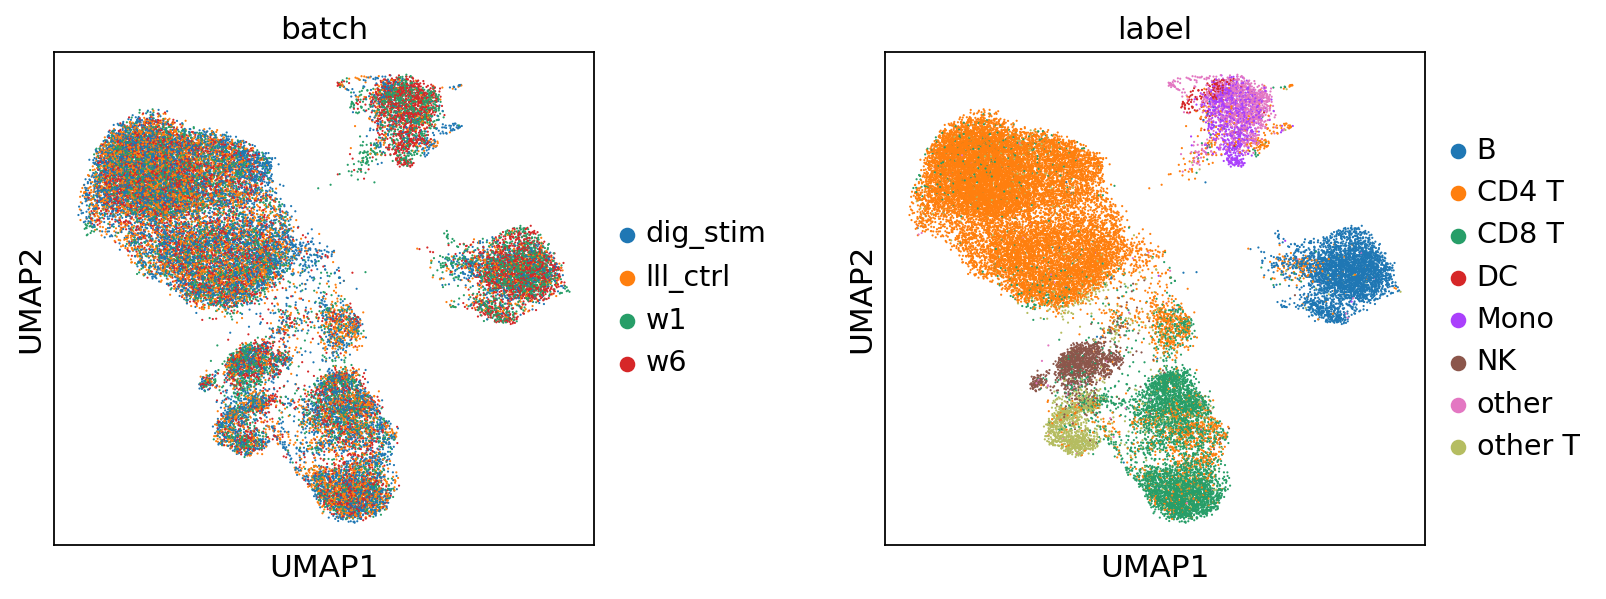

... storing 'batch' as categorical
... storing 'label' as categorical


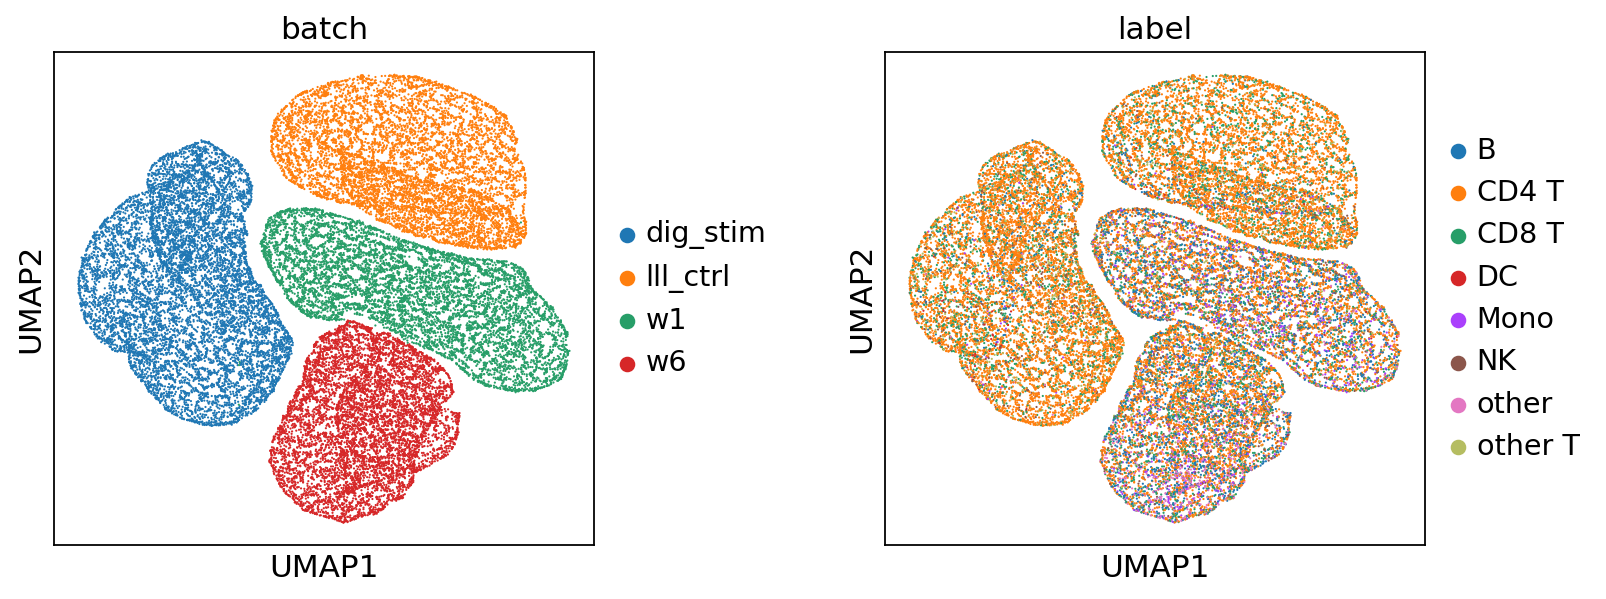

In [8]:
# Biological State
plot_umap(adata, 'z_c_joint', color=['batch', 'label'], wspace=0.4)
# Technical Noise
plot_umap(adata, 'z_u_joint', color=['batch', 'label'], wspace=0.4)

### 6.2 Modality-Specific Embeddings

We visualize the biological embeddings (`c`) for each modality (RNA, ADT, ATAC) and for the joint representation, across all 4 batches.

... storing 'axis1' as categorical
... storing 'axis2' as categorical
... storing 'label' as categorical


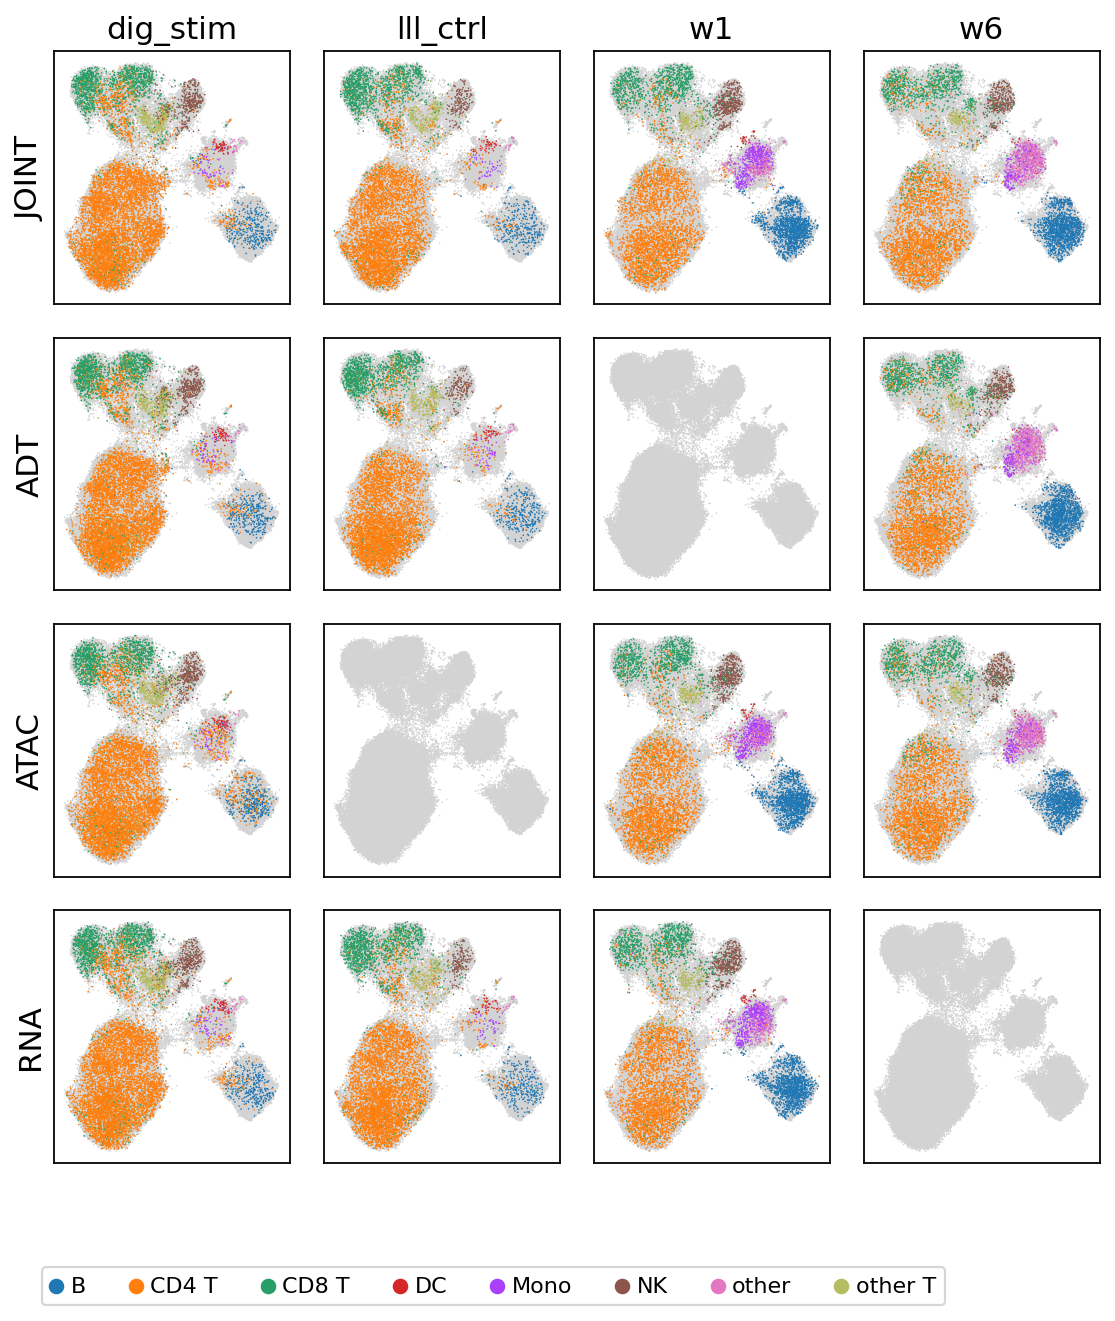

In [9]:
data_list, batch_list, cat_list, label_list = [], [], [], []

for batch, ad in outputs.items():
    valid_keys = [k for k in ad.obsm if k.startswith('z_c')]
    
    for k in valid_keys:
        data_list.append(ad.obsm[k])
        batch_list.append(ad.obs['batch'])
        
        cat_name = k.split('_')[-1].upper()
        cat_list.append(np.full(ad.n_obs, cat_name))
        label_list.append(pd.read_csv('./dataset/'+task+'/label/%s.csv'%batch, index_col=0).values.flatten())

data = np.concatenate(data_list)
axis1_ = np.concatenate(cat_list)
axis2_ = np.concatenate(batch_list)
label_ = np.concatenate(label_list)

ad = sc.AnnData(data)
ad.obs['axis1'] = axis1_
ad.obs['axis2'] = axis2_
ad.obs['label'] = label_
sc.pp.neighbors(ad, use_rep='X')
sc.tl.umap(ad)
plot_umap_grid(ad, 'axis1', 'axis2', color='label')

### 6.3 Imputed and Batch-Corrected Data

We use WNN to compute joint embeddings from the imputed and batch-corrected counts.

For efficiency, we'll use a random sample of 2000 cells.

In [ ]:
N = 2000
select = np.random.choice(list(range(len(adata))), N, replace=False)
data = {
    'x_bc_rna' : adata.obsm['x_bc_rna'][select],
    'x_bc_adt' : adata.obsm['x_bc_adt'][select],
    'x_bc_atac' : np.array(adata.obsm['x_bc_atac'][select].todense())
}

'wnn_trimodal.R' already exists. Skipping download.

Python: Executing R script 'wnn_trimodal.R' for Imputed and Batch-Corrected Data...



... storing 'batch' as categorical
... storing 'label' as categorical


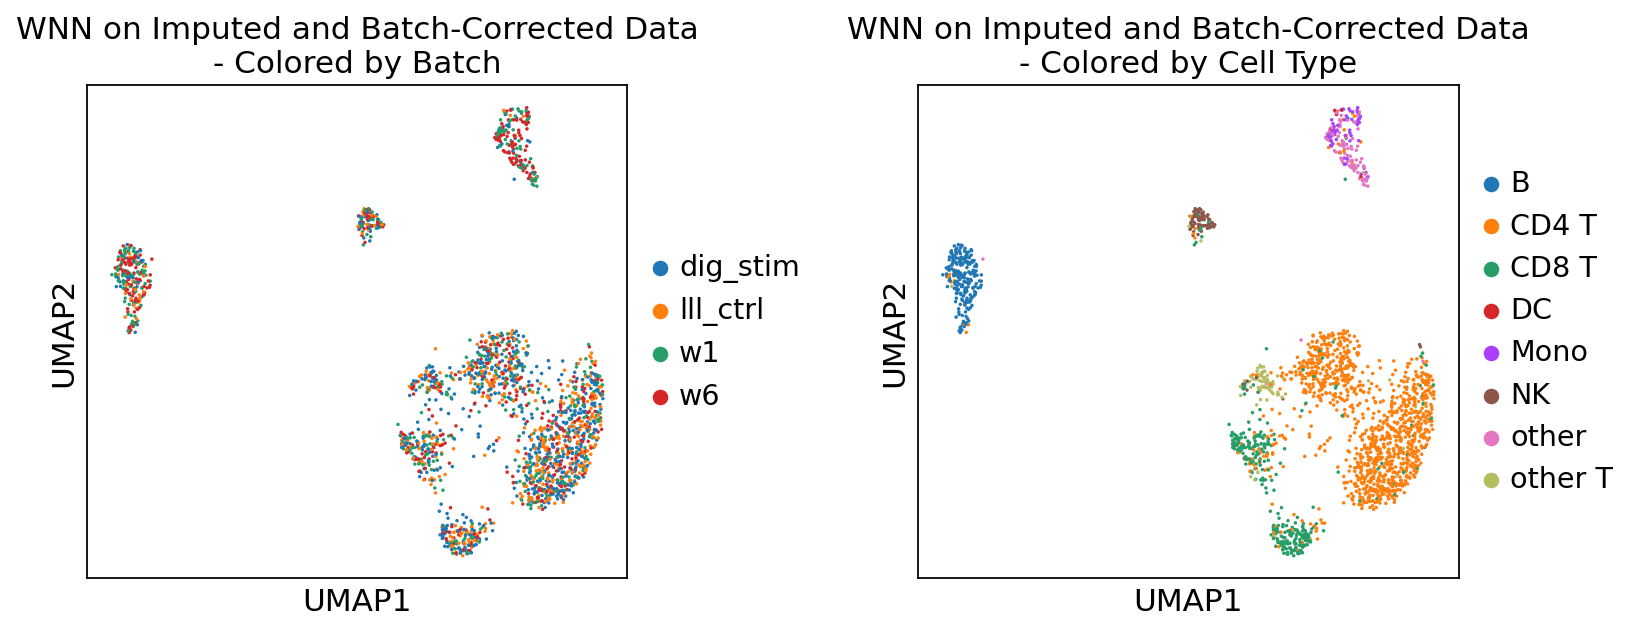

In [ ]:
temp_dirs = {"Imputed and Batch-Corrected Data": 'demo3_temp/x_bc/'}
r_script_file = 'wnn_trimodal.R' # R script for WNN analysis on RNA+ADT+ATAC data
download_script(r_script_file)

for name, temp_dir in temp_dirs.items():
	# 1. Save Python data to disk for the R script to access
	os.makedirs(temp_dir, exist_ok=True)
	data_key = Path(temp_dir).name  # 'x_bc' or 'x'
	pd.DataFrame(data[data_key+'_rna']).T.to_csv(temp_dir+'rna.csv', index=True)
	pd.DataFrame(data[data_key+'_adt']).T.to_csv(temp_dir+'adt.csv', index=True)
	pd.DataFrame(data[data_key+'_atac']).T.to_csv(temp_dir+'atac.csv', index=True)

	# 2. Execute the R script via a subprocess
	print(f"\nPython: Executing R script '{r_script_file}' for {name}...\n")
	command = ['Rscript', '--vanilla', r_script_file, temp_dir]
	result = subprocess.run(command, check=True, capture_output=True, text=True)
	# print(result.stdout) # uncomment this line to see the R script's output

	# 3. Load the UMAP results generated by R and plot them
	ad = adata[select]
	ad.obsm['X_umap'] = pd.read_csv(temp_dir+'umap_coords.csv', index_col=0).values
	sc.pp.subsample(ad, fraction=1) # Shuffle data
	sc.pl.umap(ad, color=['batch', 'label'], ncols=2, wspace=0.4, size=10,
				title=[f'WNN on {name}\n- Colored by Batch', f'WNN on {name}\n- Colored by Cell Type'])
